# Introduction{-}

Dans ce rapport, nous étudions un échantillon de données intitulé **"Ionosphere"**. Ce dernier contient des données radar qui ont été recueillies par un système à Goose Bay, au Labrador Canada. Ce système est constitué d’un réseau phasé de plusieurs antennes haute fréquence avec une puissance totale émise de l’ordre de 6,4 kilowatts. Les cibles étaient des électrons libres dans l’ionosphère. Les **bons** (classifiés «g» pour **good**) retours radar sont ceux qui mettent en évidence un certain type de structure dans l’ionosphère. Les **mauvais** («b» pour **bad**) retours sont ceux qui ne le font pas ; leurs signaux traversent l’ionosphère. 

L’échantillon contient 351 observations et **33 variables**, dont la variable **"class"** qui est celle que l'on cherche à expliquer. Les 32 variables quantitatives sont supposées continues. Nous sommes ainsi confrontés à un problème de **classification binaire**.

Le rapport se structure de la façon qui suit: dans un premier temps, il s'agit de faire une **analyste statistique** de notre échantillon de données. Ensuite, nous séparerons l'échantillon en deux groupes (*train* et *test*) et construirons puis testerons des modèles de **forêt aléatoire** pour la classification. Après celà, il s'agira de construire et de tester sur ces données un modèle de **forêt d'isolement** de détection d'anomalies. Par la suite, nous réaliserons l'**analyse par composante principale (ACP)** des données et étudierons son utilisation dans la réduction du nombre de variables ainsi que dans la détection d'anomalie. Enfin, nous mettrons en oeuvre l'**AFD descriptive et prédictive** sur ces données dans le but de discriminer les deux classes "g" et "b" d'individus. 

Tout au long du rapport, nous comparerons et interpréterons les différences entre les résultats issus de ces diverses techniques.

# Analyse statistique

On récupère dans un premier temps nos données:

In [1]:
setwd('D:/ICM 2A/Data science/UP2 - Apprentissage statistique')
rm(list=ls())
data <- read.csv(file='Ionosphere.csv', header=TRUE, sep=";")

Visualisons les différentes variables:

In [2]:
summary(data)

      a01               a02                a03               a04         
 Min.   :-1.0000   Min.   :-1.00000   Min.   :-1.0000   Min.   :-1.0000  
 1st Qu.: 0.4721   1st Qu.:-0.06474   1st Qu.: 0.4127   1st Qu.:-0.0248  
 Median : 0.8711   Median : 0.01631   Median : 0.8092   Median : 0.0228  
 Mean   : 0.6413   Mean   : 0.04437   Mean   : 0.6011   Mean   : 0.1159  
 3rd Qu.: 1.0000   3rd Qu.: 0.19418   3rd Qu.: 1.0000   3rd Qu.: 0.3347  
 Max.   : 1.0000   Max.   : 1.00000   Max.   : 1.0000   Max.   : 1.0000  
      a05               a06                a07                a08          
 Min.   :-1.0000   Min.   :-1.00000   Min.   :-1.00000   Min.   :-1.00000  
 1st Qu.: 0.2113   1st Qu.:-0.05484   1st Qu.: 0.08711   1st Qu.:-0.04807  
 Median : 0.7287   Median : 0.01471   Median : 0.68421   Median : 0.01829  
 Mean   : 0.5501   Mean   : 0.11936   Mean   : 0.51185   Mean   : 0.18135  
 3rd Qu.: 0.9692   3rd Qu.: 0.44567   3rd Qu.: 0.95324   3rd Qu.: 0.53419  
 Max.   : 1.0000   Max.   

On a 33 variables descriptives de 351 individus. 32 variables sont numériques et la variable classe est binaire ('g' ou 'b'). Quelques statistiques descriptives (min, mean, max, median) des variabes numériques sont données par la fonction summary ci-dessus. Quelques remarques :

Les 32 variables numériques sont toutes **à valeur dans l'intervalle $\left[-1,1\right]$**, ce qui laisserait peut-être penser qu'elles possèdent la même unité (ou du moins le même ordre de grandeur). Certaines semblent **centrées** (moyenne nulle), mais d'autres non.

Etudions l'écart-type des 32 variables numériques:

In [3]:
sapply(data[,-33], sd, na.rm = TRUE)

a01       a02       a03       a04       a05       a06       a07       a08 
0.4977082 0.4414348 0.5198615 0.4608101 0.4926538 0.5207499 0.5070655 0.4838509 
      a09       a10       a11       a12       a13       a14       a15       a16 
0.5634964 0.4948174 0.6221861 0.4948726 0.6528278 0.4583707 0.6180204 0.4967620 
      a17       a18       a19       a20       a21       a22       a23       a24 
0.6262668 0.5190761 0.6098283 0.5181659 0.6037675 0.5274563 0.5784509 0.5084945 
      a25       a26       a27       a28       a29       a30       a31       a32 
0.5162047 0.5500252 0.5758856 0.5079741 0.5714834 0.5135744 0.5226634 0.4683372

Les 32 variables descriptives possèdent toutes un **écart-type proche de 0.5**, du même ordre de grandeur. 

En conclusion, les variables semblent partager la même **échelle** et ont une **variance comparable**, elles ne sont néanmoins pas toutes centrée.

Ces similarités entre les différentes variables descriptives nous seront utiles plus tard, notamment lors de l'ACP, pour décider du type de prétraitement nécessaire des données avant analyse.

# Classification avec une forêt aléatoire

Le but est de construire une forêt aléatoire de haute performance qui a pour but de bien classer les observations de la variable "class" entre "g" ou "b".

Dans un premier temps, on divise notre base de données en 70% train pour l'apprentissage et 30% test (méthode hold-out pour la validation), en fixant le seed (génération des suites pseudo-aléatoires) à 1234:

In [4]:
set.seed(1234)
index <- sample(1:nrow(data),round(0.70*nrow(data)))
train <- data[index,]
test <- data[-index,]

On importe la librairie randomForest pour créer notre modèle de forêt:

In [7]:
library(randomForest)
library(Metrics)

## Forêt aléatoire non optimisée

On commence par une forêt aléatoire avec les hyperparamètres par défaut:

In [7]:
set.seed(1234)
rf <- randomForest(as.factor(class) ~ .,data=train)

Réalisons désormais la prédiction sur nos données test et mesurons la précision des prédictions:

In [8]:
p1=predict(rf,test)
accuracy(test$class, p1)

[1] 0.952381

Cela signifie qu'avec ce modèle, 95% des individus de l'ensemble test ont bien été classifiés.

Ceci nous fournit un score de référence pour la suite de notre étude.

Construisons la matrice de confusion:

In [9]:
mc1 <- table(Predicted = p1, Actual = test$class)
mc1

         Actual
Predicted  b  g
        b 40  3
        g  2 60

## Optimisation des hyperparamètres de la forêt

Afin d'optimiser notre modèle de forêt aléatoire, il est nécessaire de bien comprendre comment elles sont générées et les paramètres qui influent sur cette génération. Intéressons-nous désormais de plus près à notre modèle de forêt:

Les forêts aléatoires sont composées (comme le terme "forêt" l'indique) d'un ensemble d'arbres décisionnels. Ces arbres se distinguent les uns des autres par le sous-échantillon de données sur lequel ils sont entraînés. Ces sous-échantillons sont tirés au hasard (d'où le terme "aléatoire") dans le jeu de données initial. Il y a deux niveaux de hasard : un Bootstrapping avec remise au niveau de l’echantillon d’apprentissage, et un tirage aléatoire des variables explicative par les variables qui interviennent dans le modele.

Par conséquent, il est logique de remarquer que la fonction randomForest peut prendre en entrée plusieurs hyperparamètres qui influencent le modèle en sortie. Parmi eux:

**ntree :** Nombre d'arbres décisionnels à considérer. Il ne doit pas être trop petit pour s'assurer que chaque ligne (individu) est prédite au moins plusieurs fois.

**mtry :** Nombre de variables tirées aléatoirement à chaque coupe. 

**nodesize :** Taille minimum des noeuds terminaux. Une valeur élevée implique des arbres créés plus petits (et donc une vitesse de calcul plus rapide).

Un remarque importante pour la suite (optimisation des hyperparamètres): il est possible de prouver, en se basant sur la loi faible des grands nombres, que l'erreur moyenne décroit stochastiquement avec le nombre **ntree** d'arbres décisionnels dans la forêt.

En effet, intuitivement: les arbres d'une forêt aléatoire sont indépendants et identiquement distribués. Les arbres sont distribués de manière identique car chaque arbre est créé à l'aide d'une stratégie de randomisation répétée identiquement pour chaque arbre : Boot-strap sur les données d'apprentissage, puis création de chaque arbre en choisissant la meilleure coupe pour une variable parmi les $m$ variables sélectionnées pour le noeud. Dans l'algorithme de forêt aléatoire, les arbres sont créés sur leur propre sous-échantillon bootstrap sans tenir compte des autres arbres, ils peuvent donc être considérés comme indépendants. (C'est d'ailleurs en ce sens que l'algorithme de la forêt aléatoire est "embarassingly parallel": on peut paralléliser la construction des arbres car chaque arbre est créé indépendamment, et c'est bien grâce au calcul parallèle que les algorithmes que l'on utilise permettent de retourner des résultats en temps raisonnable). 

Dans le cas d'une classification binaire (notre cas), la loi faible des grands nombres s'applique car les arbres sont indépendants et identiquement distribués et que la variable à prédire (**class**) possède une variance finie (en temps que variable binaire à valeur dans {$0$,$1$}).

L'application de la loi faible des grands nombres dans ce cas implique que, pour chaque échantillon, l'ensemble va tendre vers une valeur moyenne particulière de prédiction pour cet échantillon lorsque le nombre d'arbres **ntree** tend vers l'infini. De plus, pour un ensemble d'échantillons donnés, une statistique qui nous intéresse sur ces échantillons convergera vers une valeur moyenne lorsque le nombre d'arbres **ntree** tend vers l'infini.

On pourrait penser qu'augmenter **ntree** pourrait causer le sur-apprentissage, mais en réalité il est prouvé que ce n'est pas le cas. Par contre, les autres hyperparamètres (**mtry** et **nodesize**) jouent sur l'over-fitting.

Dès lors, il est inutile d'essayer d'optimiser le paramètre **ntree**, il faut simplement le prendre suffisamment grand pour assurer la convergence de l'erreur.

Afin d'optimiser notre modèle, nous allons prendre un **ntree** assez grand, puis jouer sur les autres hyperparamètres (**mtry** et **nodesize**) pour obtenir une forêt haute performance. Pour cela, nous nous appuyons sur les librairies **mlr** et **caret** :

In [9]:
library(caret)
library(mlr)

La façon de procéder pour sélectionner les hyperparamètres optimaux repose sur la validation croisée. Pour chaque set d'hyperparamètres, on réalise une cross-validation sur nos données train pour avoir une idée du caractère prédictif de la forêt sur des données nouvelles. Nous avons notamment utilisé cette méthode pour trouver les hyperparamètres optimaux pour la fonction **rpart** dans le TP Arbres de Décisions.

Seulement, nous sommes ici dans un cas plus volumineux avec les forêts aléatoires. En effet, les plages de valeurs prises par les hyperparamètres sur lesquels nous voulons jouer sont larges, et le temps de calcul pour générer chaque forêt est plus conséquence, par conséquent une recherche exhaustive de type **grid-search** peut prendre beaucoup de temps. A la place, on peut considérer une méthode stochastique de type **random-search**: nous allons tirer au hasard un certain nombre fixé de sets d'hyperparamètres à tester puis sélectionner le meilleur d'entre eux à la suite des résultat de la validation croisée.

Nous proposons les deux implémentations ci-dessous, nous avons aupravant utilisé la méthode exhaustive **grid-search** sur le TP Arbres de Décisions, mais ici nous utilisons la méthode stochastique **random-search** pour alléger le temps de calcul.

In [449]:
set.seed(1234)
d.tree.mlr <- makeClassifTask(
  data=train, 
  target="class")

# Méthode de controle: random-search avec 300 triplets d'hyperparamètres tirés aléatoirement parmi les plages possibles
control_random=makeTuneControlRandom(maxit = 300L)

# Méthode de controle exhaustive: grid-search avec tous les triplets d'hyperparamètres dans les plages possibles
# Donnée en commentaire mais non utilisée ici
#control <- trainControl(method="repeatedcv", number=10, repeats=3)
#control_grid = makeTuneControlGrid()

# Méthode de validation: cross-validation à 7 blocs
resample = makeResampleDesc("CV", iters = 7L)

# Mesure à considérer: la précision des prédictions
measure = acc

# Hyperparamètres à considérer et leur plages de valeurs
param_grid_multi <- makeParamSet( 
  makeDiscreteParam("mtry", values=1:30),
  makeDiscreteParam("nodesize", values=1:40),
  makeDiscreteParam("ntree", values=500:500)
    
)

In [137]:
dt_tuneparam_multi <- tuneParams(learner='classif.randomForest', 
                                 task=d.tree.mlr, 
                                 resampling = resample,
                                 measures = measure,
                                 par.set=param_grid_multi, 
                                 control=control_random, 
                                 show.info = FALSE)
dt_tuneparam_multi

Tune result:
Op. pars: mtry=5; nodesize=14; ntree=500
acc.test.mean=0.9227891

Testons notre modèle avec les hyperparamètres optimisés:

In [428]:
rf2 <- randomForest(as.factor(class) ~ .,ntree=500,mtry=5,nodesize=14,data=train)
p2=predict(rf2,test)
accuracy(test$class, p2)

[1] 0.9809524

Cela signifie qu'avec ce modèle, 98% des individus de l'ensemble test ont bien été classifiés. Construisons la matrice de confusion :

In [429]:
mc2 <- table(Predicted = p2, Actual = test$class)
mc2

         Actual
Predicted  b  g
        b 42  2
        g  0 61

2 individus tests on été mal prédits. Les deux sont en réalité "good" et ont été prédits comme étant "bad".

**Remarque:** Afin de construire ce modèle, nous nous sommes basées sur la cross-validation car c'est une méthode de validation plus robustes vis-à-vis de la fluctuation dues au hasard et aux échantillons. Si, dans une optique "challenge", l'on souhaite uniquement augmenter l'accuracy sur notre ensemble test sans nous intéresser à la robustesse du modèle, le hasard peut jouer en notre faveur. En prenant un nombre **ntree** petit, les variations dûes au hasard autour de la valeur de convergence sont élevées, et on peut arriver à un score d'accuracy meilleur en cas de fluctuation favorable.

Mais cela n'a pas réellement de fondement autre que le hasard, il faut préférer un modèle avec **ntree** grand pour assurer la convergence de l'erreur et ne pas reposer sur un cas particulier si l'on souhaite généraliser le modèle.

On présente un tel modèle à erreur fluctuante qui, par hasard, fournit une précision supérieure du fait de l'aléatoire (l'erreur est fluctuente et le modèle peut donner des précisions variables, puisque **ntree** est petit il n'y a pas convergence comme expliqué plus haut):

In [431]:
rf3 <- randomForest(as.factor(class) ~ .,mtry=5,ntree=12,nodesize=1,data=train)
p3=predict(rf3,test)
accuracy(test$class, p3)

[1] 0.9904762

Construisons la matrice de confusion associée:

In [432]:
mc3 <- table(Predicted = p3, Actual = test$class)
mc3

         Actual
Predicted  b  g
        b 42  1
        g  0 62

Un unique individu test a été mal prédit (réalité: good, prédit: bad).

# Détection des anomalies avec une forêt d'isolement

L'algorithme des forêts d’isolement permet de calculer un score d’anomalie, c'est-à-dire une mesure qui reflète à quel point une donnée peut être considérer comme atypique. Afin de calculer ce score, l’algorithme isole la donnée en question de manière récursive : il choisit aléatoirement une variable puis sélectionne un “seuil de coupure”, puis il évalue si cela permet d’isoler la donnée en question ; si tel est le cas, l’algorithme s’arrête, sinon il choisit une autre variable et un autre seuil de coupure, et ainsi de suite jusqu’à ce que la donnée soit isolée du reste.

On s'appuie sur la librairie IsolationForest:

In [10]:
library(IsolationForest)

IsolationForest 0.0-26 


## Forêt d'isolement non paramétrée

On construit une forêt d'isolement avec les hyperparamètres par défaut:

**num_trees**=100 : nombre d'arbres construits dans la forêt.

**nRowSamp**=nrow(train) : taille du sous-échantillon, doit être inférieure ou égale à la taille de l'échantillon train.

**rFactor**=1 : facteur de randomisation, variant de 0 (déterminisme total) à 1 (aléatoire total).

**hlim**=(ceiling(log2(nrow(train))) : limite de la hauteur maximale de la forêt.

**nmin**= 1 : nombre minimum d'échantillons pour former un noeud terminal.


In [11]:
set.seed(1234)

iso <- IsolationTrees(train)

# calcul des scores d'anomalie des données test 
anomaly_scores <- AnomalyScore(test, iso)$outF

Les indices des observations avec les 5 plus hauts scores d'anomalie sont les suivants:

In [12]:
hauts_scores_indices <- order(anomaly_scores, decreasing=T)
hauts_scores_indices[1:5]

[1] 10 26 76 20 21

Ces indices sont les indices des individus en tant qu'éléments de la liste **test**, retrouvons les indices de base (en tant qu'élément du dataset d'origine) de ces individus:

In [14]:
library(rlist)

In [16]:
ind <- 1:351
index_test=ind[!ind %in% index]
li=list()
for (j in hauts_scores_indices[1:5]) {
  li[length(li)+1]=index_test[j]
}
t(li)

18,78,233,54,56


Les scores des anomalies associées sont respectivement :

In [17]:
anomaly_scores[hauts_scores_indices[1:5]]

[1] 0.6909864 0.6772392 0.6608605 0.6590167 0.6583797

Les indices des observations avec les 5 plus bas scores d'anomalie sont les suivants:

In [18]:
bas_scores_indices <- order(anomaly_scores, decreasing=F)
bas_scores_indices[1:5]

[1] 48 89 98 99 77

Ces indices sont les indices des individus en tant qu'éléments de la liste **test**, retrouvons les indices de base (en tant qu'élément du dataset d'origine) de ces individus:

In [19]:
li=list()
for (j in bas_scores_indices[1:5]) {
  li[length(li)+1]=index_test[j]
}
t(li)

162,294,331,332,238


Les scores des anomalies associées sont respectivement :

In [20]:
anomaly_scores[bas_scores_indices[1:5]]

[1] 0.3476600 0.3476600 0.3530095 0.3541744 0.3556986

Seulement, une fois en possession de ces résultats, on ne peut comme dans les parties précédentes calculer un taux d'erreur ou de précision. La raison est simple: il s'agit ici d'un **modèle non supervisé**. En effet, nos données ne sont pas labelisées: on ne sait pas lesquels parmi elles sont effectivement des outliers.

On peut cependant tout de même réaliser une sorte de vérification, proposons plusieurs méthodes:

Une manière de faire serait d'extraire échantillon de taille raisonnable, calculer les scores anomalies sur cet échantillon, et demander à un expert de confirmer les résultats en labelisant cet échantillon par des moyens autres que statistiques: on tombe alors sur un modèle dit **semi-supervisé**. Malheureusement, nous ne disposons pas d'experts pour réaliser cette méthode dans notre cas.

Une seconde méthode serait d'étudier la différence de la variance, de certaines variables, avec et sans les anomalies et choisir la combinaison d’hyperparamètres qui donne le plus grand nombre de variables avec une différence de variance statistiquement significative. En effet, le retrait des anomalies a forcément pour effet une diminution de la variance (écarts à la moyenne en général importants pour les outliers). Afin de mesurer si une différence de variance est statistiquement significative on se base sur une test d'ANOVA appelé **Fligner Killeen** (basé sur le test de **Levene**), qui teste l'hypothèse $H_0$ supposant que les variances de deux échantillons sont égales et fournit une **p-valeur**: si la p-valeur est inférieure à $0.05$, on peut conclure que le test est significatif et que les variances sont différentes. Essayons cette méthode de validation :

In [38]:
set.seed(1234)
iso1 <- IsolationTrees(train,ntree=500,hlim=200,nmin=5,rFactor=0,nRowSamp=3)
anomaly_scores1 <- AnomalyScore(test, iso1)$outF
hauts_scores_indices1 <- order(anomaly_scores1, decreasing=T)
bas_scores_indices1 <- order(anomaly_scores1, decreasing=F)

Observons les p-valeur du test sur les variables avant et après avoir retiré les individus au plus haut score d'anomalie:

In [39]:
for (i in 1:32){
  sample1=test[,i]
  sample2=test[-hauts_scores_indices1[1:10],i]
  y <- c(sample1, sample2)
  group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
  print(fligner.test(y,group)$p.value)
}

[1] 0.1497913
[1] 0.2811646
[1] 0.2266602
[1] 0.9243086
[1] 0.4969533
[1] 0.7474381
[1] 0.172346
[1] 0.6553336
[1] 0.6429735
[1] 0.3454602
[1] 0.7574907
[1] 0.7618899
[1] 0.4997442
[1] 0.8555822
[1] 0.7142917
[1] 0.372936
[1] 0.591967
[1] 0.7071677
[1] 0.8659419
[1] 0.9617319
[1] 0.6819971
[1] 0.9443135
[1] 0.2523647
[1] 0.2213158
[1] 0.7440451
[1] 0.5130427
[1] 0.4763579
[1] 0.3917741
[1] 0.3831919
[1] 0.295928
[1] 0.8731856
[1] 0.9578232


Aucune des p-valeur ne permet de conclure à une différence de variance significative.

Essayons une autre combinaison des hyperparamétres d'isolationTree qui est ntree=500,hlim=100,nmin=1,rFactor=1,nRowSamp=3 :

In [44]:
set.seed(1234)
iso2 <- IsolationTrees(train,ntree=500,hlim=100,nmin=5,rFactor=1,nRowSamp=3)
anomaly_scores2 <- AnomalyScore(test, iso2)$outF
hauts_scores_indices2 <- order(anomaly_scores2, decreasing=T)

Au lieu de regarder les p-valeurs une par une, on écrit une fonction qui compte le nombre de variables observant une différence significative de variance après retrait des outliers:

In [45]:
compteur<-function(){
  cpt=0
  for (i in 1:32)
  {
    sample1=test[-hauts_scores_indices2[1:10],i]
    sample2=test[-hauts_scores_indices2[1:10],i]
    y <- c(sample1, sample2)
    group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
    if (fligner.test(y,group)$p.value<0.05)
    {cpt<-cpt+1}
  }
  print(cpt)}
compteur()

[1] 0


Encore une fois, le test statistique de différence de variance n'est pas significatif pour cette combinaison d'hyperparametres.

On a essayé une cinquantaine de combinaison d'hyperparamètres diversifiées, et le test de flinger ne devient siginficatif que lorsqu'on enleve un nombre important d'observations (à peu prés 20%) ce qui n'est pas concluant car nous retirons alors plus que les possibles outliers.

La forêt d'isolement retire effectivement des individus et diminue la variance, pour s'en convaincre, observons la somme des differences des variances des variables aves et sans les observations aberrantes: 

In [46]:
sum(sapply(test[1:32], var)-sapply(test[1:32][-hauts_scores_indices1[1:10],], var))
sum(sapply(test[1:32], var)-sapply(test[1:32][-hauts_scores_indices2[1:10],], var))

[1] 1.333108

[1] 1.842266

On voit bien une amélaioration, mais cette amélioration n'est pas significative et visible pour chaque variable une par une avec nos tests ANOVA (que ce soit le test de Flinger ou de Levene, issu de la librairie **car**).

Une autre approche serait de comparer visuelement les distributions des variables qui nous semblent impactées par le retrait des outliers, en visualisant leur répartition avec et sans les observations aberrantes :

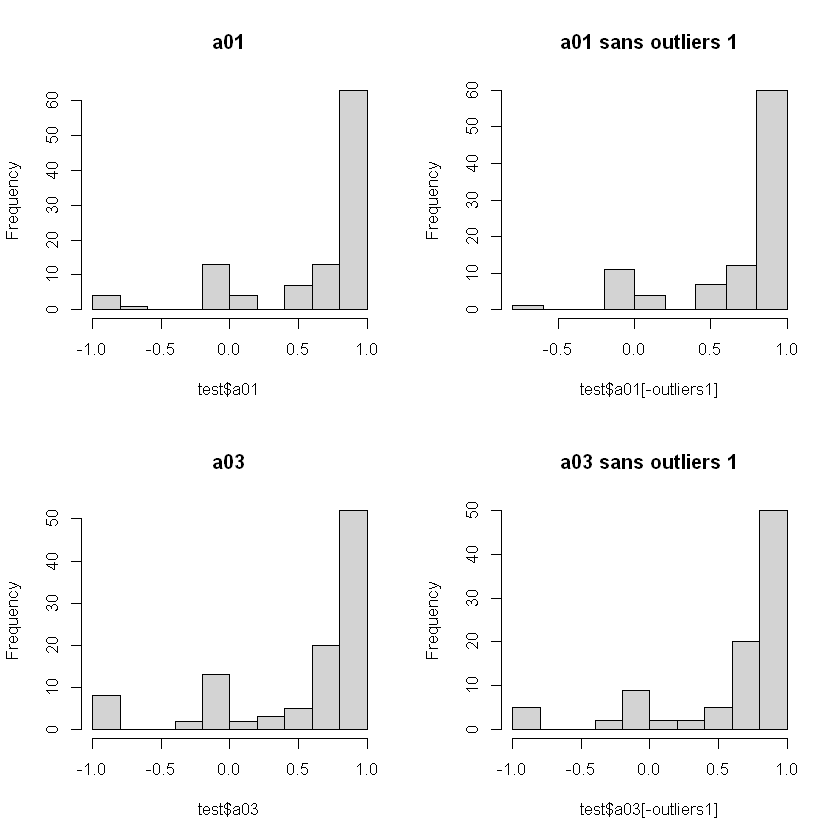

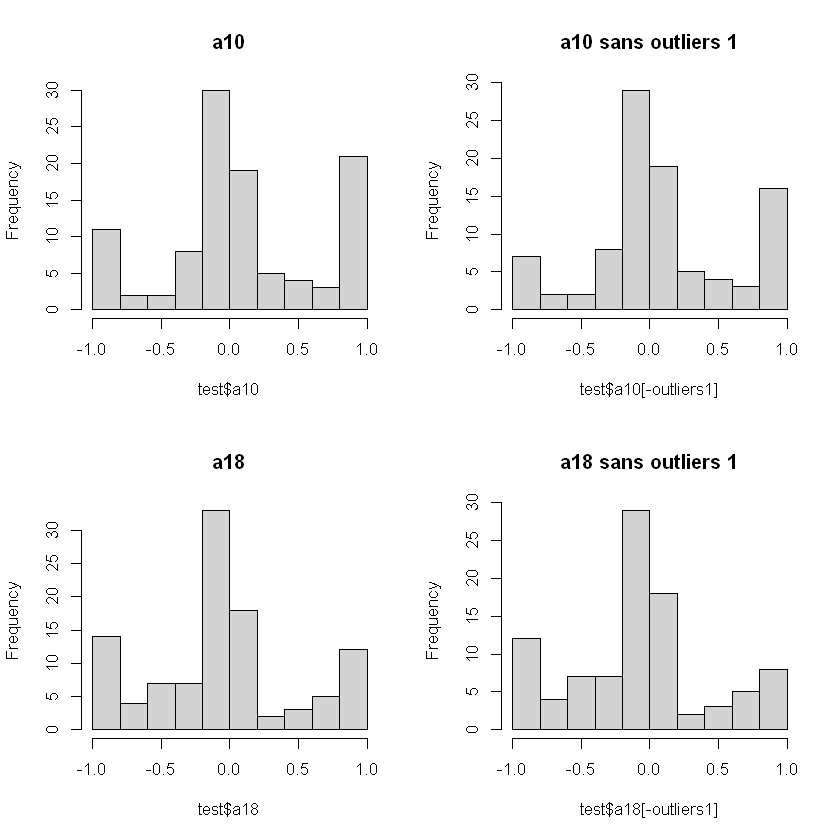

In [47]:
outliers1=hauts_scores_indices1[1:10]
outliers2=hauts_scores_indices2[1:10]


par(mfrow=c(2,2))
hist(test$a01,main='a01')
hist(test$a01[-outliers1],main='a01 sans outliers 1')
hist(test$a03,main='a03')
hist(test$a03[-outliers1],main='a03 sans outliers 1')
par(mfrow=c(2,2))
hist(test$a10,main='a10')
hist(test$a10[-outliers1],main='a10 sans outliers 1')
hist(test$a18,main='a18')
hist(test$a18[-outliers1],main='a18 sans outliers 1')

On voit bien que le retrait des outliers permet de légèrement diminuer la distribution sur les extrêmes ainsi qu'au centre, c'est cohérent du fait que les outliers sont souvent introduits par erreur et ont des valeurs bien souvent absurdes (maximale, minimale ou nulle). Observons cela pour les outliers issues du second set d'hyper-paramètres présenté:

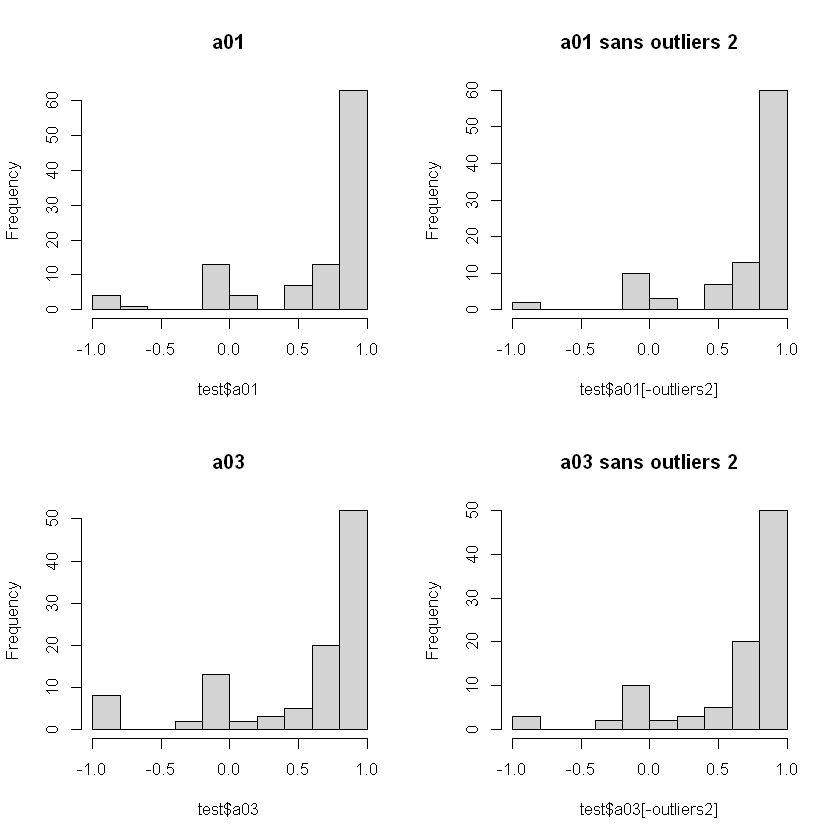

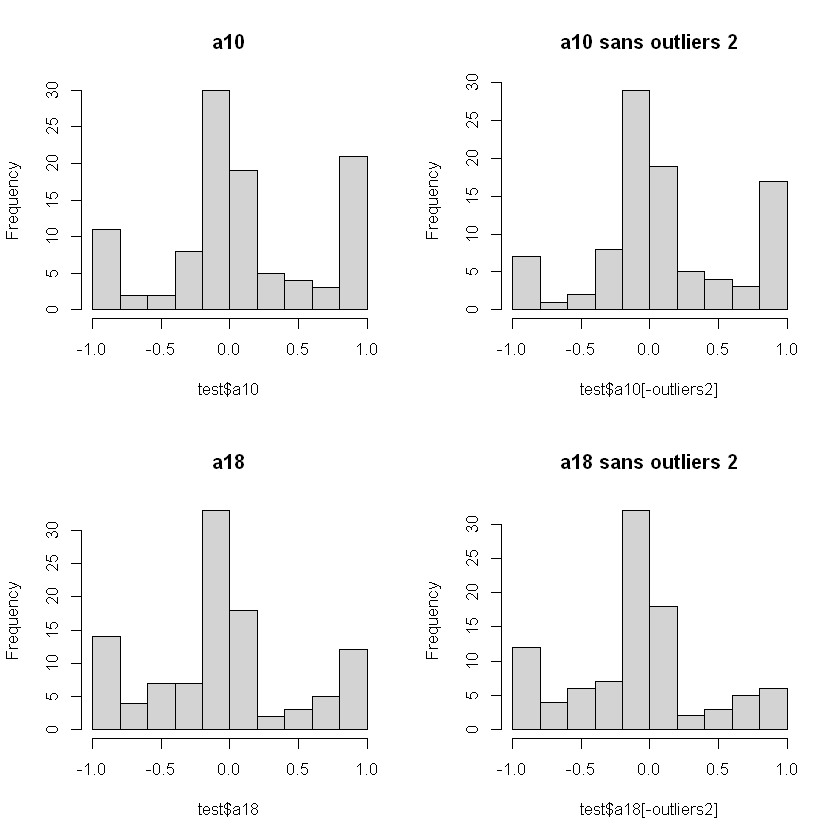

In [48]:
par(mfrow=c(2,2))
hist(test$a01,main='a01')
hist(test$a01[-outliers2],main='a01 sans outliers 2')
hist(test$a03,main='a03')
hist(test$a03[-outliers2],main='a03 sans outliers 2')


par(mfrow=c(2,2))
hist(test$a10,main='a10')
hist(test$a10[-outliers2],main='a10 sans outliers 2')
hist(test$a18,main='a18')
hist(test$a18[-outliers2],main='a18 sans outliers 2')

Même constat que précédemment, on remarque que qu'il ya une difference legere entre les distributions de ces 4 variables avec et sans outliers au centre et aux extrêmes. Mais cela reste une comparaison visuelle, qui ne suffit pas réellement pour valider le modele lorsque les test statistiques ne sont pas significatifs dans ce contexte et permet encore moins de juger quels hyperparamètres sont les plus efficaces et de sélectionner les hyperparamètres optimaux.

Finalement, on se rend compte de la difficulté de superviser un modèle qui par définition est **non supervisé**, surtout lorsque les tests statistiques ne sont pas significatifs. Enfin, tentons une dernière approche pour motiver le choix des hyperparamètres de notre forêt.


Une autre manière de faire repose sur l'ACP. En effet, la projection sur le premier plan factoriel de nos données permet souvent de remarquer à vue d'oeil les données dites "aberrantes". On désigne alors ici par données "aberrantes" des données qui, bien que correctement représentées par les deux premières composantes principales (elles suivent donc le même "modèle" que le reste des individus), possèdent des valeurs dans les extrêmes. Pour comprendre ce concept simplement, on peut donner l'exemple simple d'un set d'individus décrits par deux variables "poids" et "taille". En supposant dans le cas le plus simple que le poids est une fonction affine de la taille, tous les être humains seront sur une droite qui sera décrite par le premier axe factoriel. Un homme extrêmement grand sera alors correctement projeté sur ce plan, mais apparaîtra dans les valeurs extrêmes pour cette composante. C'est ce que l'on désigne par des données aberrantes **extrêmes**.

On verra dans la suite que cette définition des données aberrantes est limitée, car en réalité, il y a un autre type de données que l'on pourrait considérer comme aberrantes: les données qui ne suivent pas du tout le même modèle que les autres, et qui seront donc par conséquent mal représentés par les premières composantes principales de l'ACP. Si l'on reprend notre exemple simple du paragraphe précédent, ce serait alors le cas si l'on avait un set de valeurs issues de mesures faites sur un animal (par exemple une souris), alors que les autres individus sont humains. Il sera donc mal projeté sur les premières composantes principales, et aller chercher ces individus mal projeté est une manière de faire pour détecter ce type d'outliers "non conformes au modèle" via l'ACP. On étudiera cette méthode dans la partie suivante.

Pour l'instant, on se limitera à représenter dans le premier plan factoriel les outliers détectés par notre forêt d'isolement, en espérant qu'ils soient effectivement des outliers "aux valeurs extrêmes" (et qui seront donc isolés sur le premier plan factoriel).

Réalisons donc l'ACP:

In [51]:
library(ade4)
library(rgl)
acp <- dudi.pca(test[,-33], center = T,scannf=FALSE, nf=3)

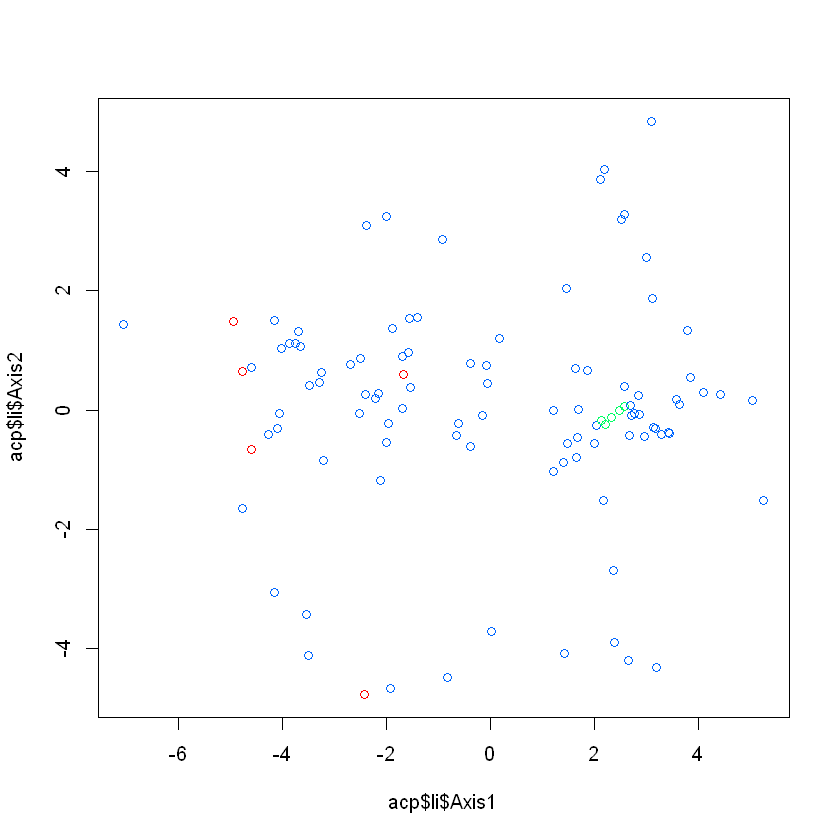

In [81]:
couleurs <- rep(rainbow(5)[4], nrow(test))
couleurs[hauts_scores_indices[1:5]] <- rainbow(5)[1]
couleurs[bas_scores_indices[1:5]] <- rainbow(5)[3]
plot(acp$li$Axis1, acp$li$Axis2, col = couleurs)

En rouge sont représentées les 5 observations avec les plus hauts scores d'anomalie, que l'on considère comme outliers. On remarque que 3 des observations parmi les 5 sélectionnées comme outliers semblent effectivement isolées sur le 1er plan factoriel. Le fait que des supposés outliers soit situé plus au centre que les autres peut signifier qu'ils présentent un comportement isolé sur d'autres composantes factoriels que les deux premières, ou que notre modèle de forêt d'isolement n'est pas correctement paramétré pour nos données.

En vert sont représentées les 5 observations avec les plus bas scores d'anomalie, on remarque qu'elles sont regroupées avec une grande partie des observation dans un cluster.

Remarquons que le choix du seuil des 5 observations pour les considérés comme outlier est arbitraire, c'est là à nouveau un paramètre à modifier pour l'adapter à nos données. Souvent, on utilise un taux appelé **contamination rate** entre $0$ et $1$ qui donne le pourcentage des observations ayant les plus hauts scores d'anomalies que l'on choisit de considérer comme outliers.

Une autre façon de conforter nos résultats repose sur l'analyse et la comparaison de la variance des observations sur les composantes principales avant et après avoir retirer les outliers.

Avant de retirer les outliers, on a les variances suivantes sur les deux premières composantes principales:

In [52]:
var(acp$li$Axis1)
var(acp$li$Axis2)

[1] 8.507193

[1] 3.421857

Après avoir retiré les outliers, on a les variances suivantes sur les deux premières composantes principales:

In [53]:
var(acp$li$Axis1[-hauts_scores_indices[1:5]])
var(acp$li$Axis2[-hauts_scores_indices[1:5]])

[1] 7.962228

[1] 3.318412

In [55]:
sample1=acp$li$Axis1[-hauts_scores_indices[1:5]]
sample2=acp$li$Axis1
y <- c(sample1, sample2)
group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
fligner.test(y,group)


	Fligner-Killeen test of homogeneity of variances

data:  y and group
Fligner-Killeen:med chi-squared = 0.014963, df = 1, p-value = 0.9026


In [56]:
sample1=acp$li$Axis2[-hauts_scores_indices[1:5]]
sample2=acp$li$Axis2
y <- c(sample1, sample2)
group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
fligner.test(y,group)


	Fligner-Killeen test of homogeneity of variances

data:  y and group
Fligner-Killeen:med chi-squared = 0.081151, df = 1, p-value = 0.7757


On observe donc que la variance diminue  après avoir retiré les outliers. Par exemple, la baisse en pourcentage sur la 2ème composante est due au fait que l'on a considéré comme outlier le point le plus extrémal sur l'axe $y$ dans le premier plan factoriel comme on a vu sur la projection. Néanmoins, bien que les p-valeurs soient plus représentatives que dans l'étude sans ACP, elles ne sont toujours pas sous le seuil significatif des $0,5$.

Cela conforte notre résultat du fait que souvent, les données dites "aberrantes" augmentent la variance en se situant sur des extrêmes. Néanmoins, ce modèle ne semble pas assez adapté à nos données du fait de la p-valeur, essayons d'optimiser les hyperparamètres avec cette méthode.

## Modification des hyperparamètres pour s'adapter à nos données

Bien qu'il s'agisse d'un modèle non supervisé, les différentes méthodes de validations décrites plus tôt nous pousse à nous intéresser aux hyperparamètres que l'algorithme des forêts d'isolement prend en entrée pour adapter le modèle au mieux à nos données.

Rappelons les différents hyperparamètres et leur role dans la construction de la forêt:

**num_trees**: nombre d'arbres construits dans la forêt.

**nRowSamp**=: taille du sous-échantillon, doit être inférieure ou égale à la taille de l'échantillon train.

**rFactor**=1 : facteur de randomisation, variant de 0 (déterminisme total) à 1 (aléatoire total).

**hlim** : limite de la hauteur maximale de la forêt.

**nmin** : nombre minimum d'échantillons pour former un noeud terminal.

Observons le comportement lorsque nous réduisons **num_tree** et **hlim**:

In [58]:
set.seed(1234)

iso <- IsolationTrees(x=train,ntree=10,hlim=3)

# calcul des scores d'anomalie des données test
anomaly_scores <- AnomalyScore(test, iso)$outF

# observations avec les plus hauts scores d'anomalies et les plus bas scores
hauts_scores_indices <- order(anomaly_scores, decreasing=T)
bas_scores_indices <- order(anomaly_scores, decreasing=F)
# ACP et projection sur le 1er plan factoriel
acp <- dudi.pca(test[,-33], center = T,scannf=FALSE, nf=3)

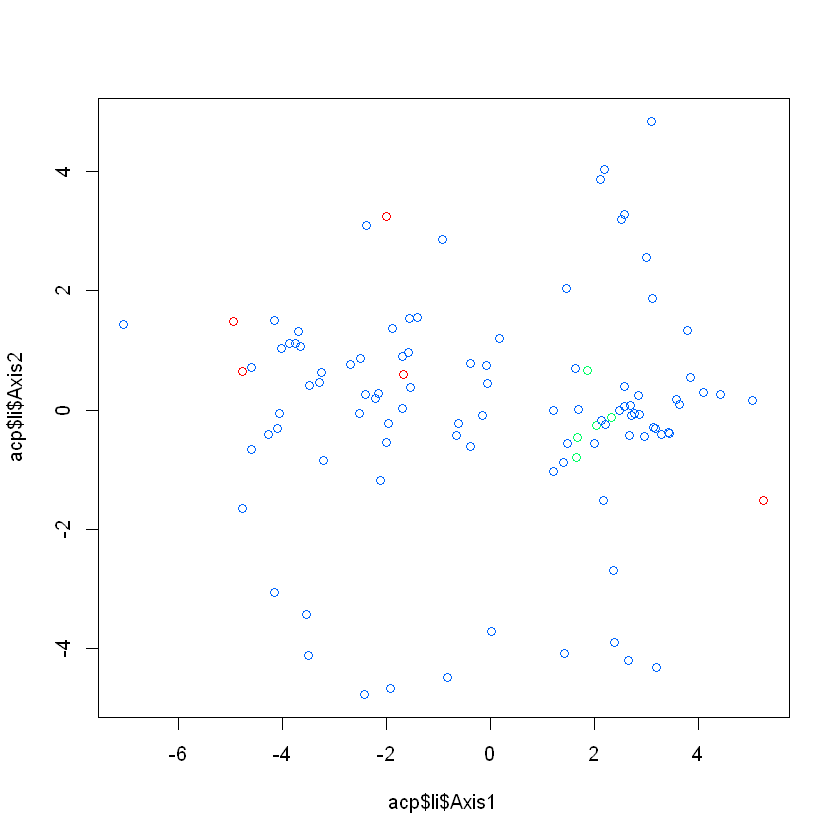

In [85]:
couleurs <- rep(rainbow(5)[4], nrow(test))
couleurs[hauts_scores_indices[1:5]] <- rainbow(5)[1]
couleurs[bas_scores_indices[1:5]] <- rainbow(5)[3]
plot(acp$li$Axis1, acp$li$Axis2, col = couleurs)

On observe à vue d'oeil sur le 1er plan factoriel que ce modèle semble moins bien décrire les outliers dits "extremaux" que le 1er. En réduisant la taille et la hauteur de la forêt, celle-ci semble être moins précise et adaptée à nos données.

Réalisons le test d'égalité de variance sur les deux premières composantes:

In [59]:
sample1=acp$li$Axis1[-hauts_scores_indices[1:5]]
sample2=acp$li$Axis1
y <- c(sample1, sample2)
group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
fligner.test(y,group)


	Fligner-Killeen test of homogeneity of variances

data:  y and group
Fligner-Killeen:med chi-squared = 0.071412, df = 1, p-value = 0.7893


In [60]:
sample1=acp$li$Axis2[-hauts_scores_indices[1:5]]
sample2=acp$li$Axis2
y <- c(sample1, sample2)
group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
fligner.test(y,group)


	Fligner-Killeen test of homogeneity of variances

data:  y and group
Fligner-Killeen:med chi-squared = 0.029655, df = 1, p-value = 0.8633


Les p-valeurs confirment que le modèle n'est pas aussi bien adapté.

Observons le comportement lorsque nous augmentons **nmin**:

In [61]:
set.seed(1234)

iso <- IsolationTrees(x=train,nmin=10)

# calcul des scores d'anomalie des données test
anomaly_scores <- AnomalyScore(test, iso)$outF

# observations avec les plus hauts scores d'anomalies et les plus bas scores
hauts_scores_indices <- order(anomaly_scores, decreasing=T)
bas_scores_indices <- order(anomaly_scores, decreasing=F)

# ACP et projection sur le 1er plan factoriel
acp <- dudi.pca(test[,-33], center = T,scannf=FALSE, nf=3)

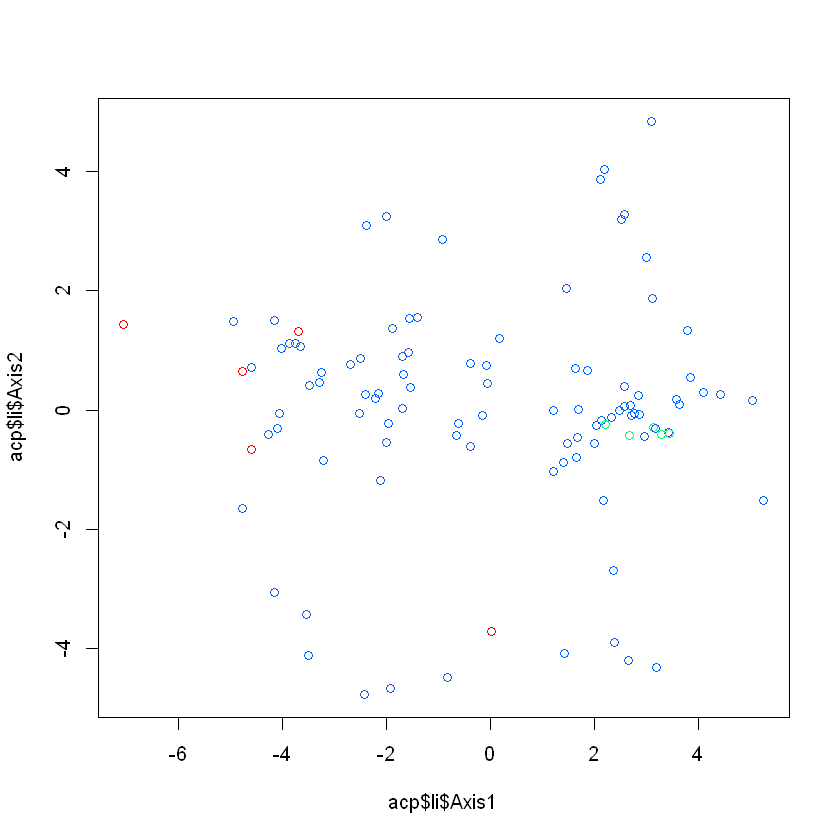

In [87]:
couleurs <- rep(rainbow(5)[4], nrow(test))
couleurs[hauts_scores_indices[1:5]] <- rainbow(5)[1]
couleurs[bas_scores_indices[1:5]] <- rainbow(5)[3]
plot(acp$li$Axis1, acp$li$Axis2, col = couleurs)

On observe qu'en augmentant **nmin** le nombre minimum d'échantillons pour former un noeud terminal, certains des outliers les plus isolés sont désormais détectés par la forêt. A nouveau, il est important de remarquer qu'il ne s'agit pas d'une règle générale mais d'une observation spécifique à nos données et à ce modèle.

In [64]:
sample1=acp$li$Axis1[-hauts_scores_indices[1:5]]
sample2=acp$li$Axis1
y <- c(sample1, sample2)
group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
fligner.test(y,group)


	Fligner-Killeen test of homogeneity of variances

data:  y and group
Fligner-Killeen:med chi-squared = 0.016956, df = 1, p-value = 0.8964


In [63]:
sample1=acp$li$Axis2[-hauts_scores_indices[1:5]]
sample2=acp$li$Axis2
y <- c(sample1, sample2)
group <- as.factor(c(rep(1, length(sample1)), rep(2, length(sample2))))
fligner.test(y,group)


	Fligner-Killeen test of homogeneity of variances

data:  y and group
Fligner-Killeen:med chi-squared = 0.028497, df = 1, p-value = 0.8659


Les p-valeur ne nous permettent toujours pas de valider le modèle. On se rend compte (après une cinquantainte de tests) que cette méthode quantitative de validation ne nous a jamais permis d'obtenir une p-valeur inférieure à 5% en retirant simplement les 5 individus avec le plus grand score d'anomalie. On se concentre sur l'aspect visuel des outliers dans le premier plan factoriel pour optimiser notre modèle.

Finalement, en jouant sur les différents types d'hyperparamètres, on tente d'obtenir un modèle qui s'adapte bien à nos données:

In [71]:
set.seed(1234)
iso <- IsolationTrees(x=train,ntree=1000,hlim=5,nmin=1,rFactor=1,nRowSamp=1)

# calcul des scores d'anomalie des données test
anomaly_scores <- AnomalyScore(test, iso)$outF

# observations avec les plus hauts scores d'anomalies et les plus bas scores
hauts_scores_indices <- order(anomaly_scores, decreasing=T)
bas_scores_indices <- order(anomaly_scores, decreasing=F)

# ACP et projection sur le 1er plan factoriel
acp <- dudi.pca(test[,-33], center = T,scannf=FALSE, nf=3)
contamination_rate <- 0.07

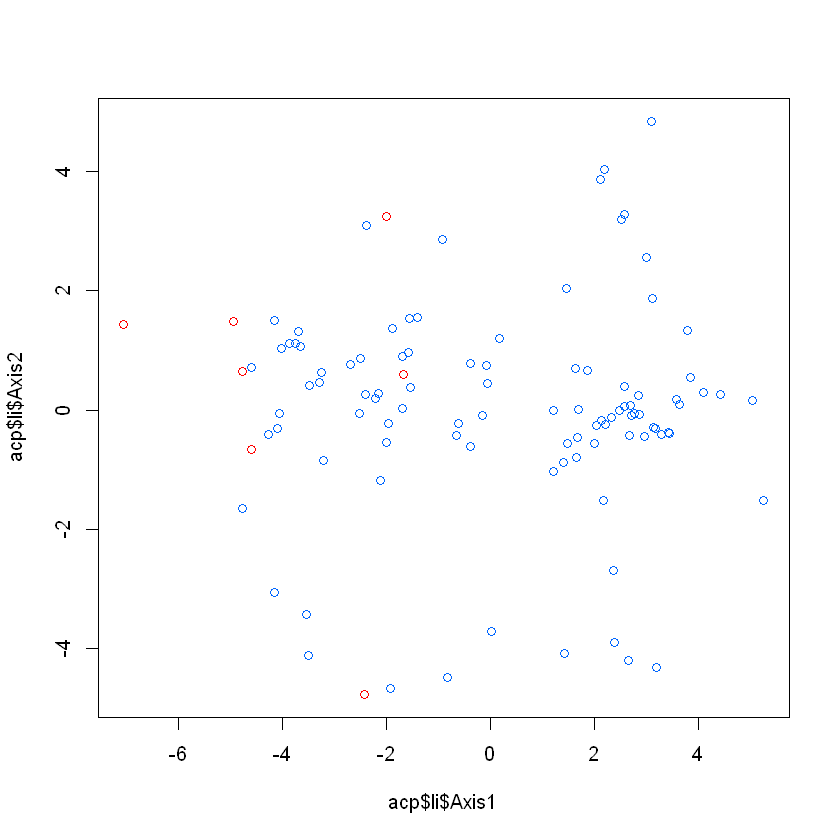

In [89]:
couleurs <- rep(rainbow(5)[4], nrow(test))
couleurs[hauts_scores_indices[1:round(nrow(test)*contamination_rate)]] <- rainbow(5)[1]
plot(acp$li$Axis1, acp$li$Axis2, col = couleurs)
compteur()

Les indices des individus outliers sont les suivants, en tant qu'éléments de **test**:

In [91]:
hauts_scores_indices[1:7]

[1] 10 20 68 51 26 21 53

Et en tant qu'éléments du dataset d'origine, ils ont pour indice:

In [92]:
li=list()
for (j in hauts_scores_indices[1:7]) {
  li[length(li)+1]=index_test[j]
}
t(li)

18,54,207,167,78,56,171


Finalement, avec un **contamination rate** (pourcentage fixant seuil de sélection des outliers) de 0.07 et les hyperparamètres sélectionnés, on observe une description assez convenable des outliers extremaux. A nouveau, le fait qu'un point qui semble central soit détecté comme outlier peut être dû au fait qu'il présente des caractéristiques abberrantes sur d'autres composantes principales que les deux premières (par exemple si c'est un autre type d'outlier que ceux décrits plus haut).

Avant de retirer les outliers, on a les variances suivantes sur les trois premières composantes principales:

In [72]:
var(acp$li$Axis1)
var(acp$li$Axis2)
var(acp$li$Axis3)

[1] 8.507193

[1] 3.421857

[1] 2.972017

Après avoir retiré les outliers, on a les variances suivantes:

In [73]:
var(acp$li$Axis1[-hauts_scores_indices[1:round(nrow(test)*contamination_rate)]])
var(acp$li$Axis2[-hauts_scores_indices[1:round(nrow(test)*contamination_rate)]])
var(acp$li$Axis3[-hauts_scores_indices[1:round(nrow(test)*contamination_rate)]])

[1] 7.700215

[1] 3.268599

[1] 2.842536

Finalement, modifier les hyperparamètres et le taux de contamination a permis de réduire la variance des composantes principales, et la projection sur le premier plan factoriel montre des outliers isolés visuellement. Ceci donne une idée de l'efficacité du modèle pour la détection d'anomalie en l'absence de labelisation.